In [1]:
#imports for typing
import pandas
import numpy
import sklearn
import datasets

#Real imports
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
dataset : datasets.dataset_dict.DatasetDict = load_dataset("imdb")

Reusing dataset imdb (C:\Users\segod\.cache\huggingface\datasets\imdb\plain_text\1.0.0\e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
x_train : list = dataset["train"][:]["text"]
y_train : list = dataset["train"][:]["label"]

x_test : list = dataset["test"][:]["text"]
y_test : list = dataset["test"][:]["label"]

-----------------------------------

## Logistic Regression

We use the following features :

    1 if "no" appear in the doc, 0 otherwise
    The count of first and second pronouns in the document
    1 if "!" is in the document, 0 otherwise
    log(word count in the document)
    Number of words in the document which are in the positive lexicon
    Number of words in the document which are in the negative lexicon
    -----------
    Number of "."
    Number of words of length < 3 characters
    Number of ":" (simplist version of a smiley, could do a regexp)


#### Vader Sentiment

In [4]:
vs : pandas.core.frame.DataFrame = pd.read_csv("vader_lexicon.txt", sep="\t", names=["TOKEN", "MEAN-SENTIMENT-RATING", "STANDARD DEVIATION", "RAW-HUMAN-SENTIMENT-RATINGS"])
vs.head()

,TOKEN,MEAN-SENTIMENT-RATING,STANDARD DEVIATION,RAW-HUMAN-SENTIMENT-RATINGS
0,$:,-1.5,0.80623,"[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]"
1,%),-0.4,1.01980,"[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]"
2,%-),-1.5,1.43178,"[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]"
3,&-:,-0.4,1.42829,"[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]"
4,&:,-0.7,0.64031,"[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]"


In [5]:
vs_dict : dict = dict(zip(vs.TOKEN, vs["MEAN-SENTIMENT-RATING"]))

#### Feature building

In [6]:
def get_features(review : str):
    """
    Get the features of a string for the logistic regression
    
    Parameters
    ----------
    review : str
        A review of the dataset

    Returns
    -------
    ints
        The features
    """
    #init
    threshold : float = 1.9
    feature_no : int = 0
    feature_pronun : int = 0
    feature_pos : int = 0
    feature_neg : int = 0
    feature_wlen : int = 0
    str_split : str = review.split()

    if "no" in str_split:
        feature_no = 1
    
    for word in str_split:
        if word in vs_dict:
            if vs_dict[word] < -threshold:
                feature_neg += 1
            elif vs_dict[word] > threshold:
                feature_pos += 1
        if word == "you" or word == "I":
            feature_pronun += 1
        if len(word) <= 3:
            feature_wlen += 1
    
    feature_smiley : int = review.count(":")
    feature_excl : int = (review.find("!") != -1)
    feature_log : float = np.log(len(str_split))
    feature_dot : int = review.count(".")
    return feature_no, feature_pronun, feature_excl, feature_log, feature_pos, feature_neg, feature_dot, feature_wlen, feature_smiley



def logistic_transformation(x : list):
    """
    Get the features all dataset x for the logistic regression
    
    Parameters
    ----------
    x : list
        List of strings

    Returns
    -------
    numpy.ndarray
        Features of each string
    """
    nbr_features : int = 9
    res : numpy.ndarray = np.zeros((len(x), nbr_features))
    for i, elt in enumerate(x):
        res[i][0], res[i][1],res[i][2],res[i][3],res[i][4], res[i][5], res[i][6],res[i][8], res[i][7] = get_features(elt)
    return res

In [7]:
%%time
lr_x_train : numpy.ndarray = logistic_transformation(x_train)

Wall time: 1.04 s


In [8]:
%%time
lr_x_test : numpy.ndarray = logistic_transformation(x_test)

Wall time: 1.01 s


In [9]:
print(lr_x_train)

[[  0.   4.   1. ...  27.   3.  55.]
 [  0.   5.   0. ...  12.   0. 168.]
 [  0.   2.   0. ...  11.   0.  54.]
 ...
 [  0.  10.   1. ...  18.   2. 123.]
 [  0.   4.   0. ...   8.   0.  86.]
 [  0.   3.   0. ...   6.   0.  57.]]


We compute the logistic regression with the help of sklearn

In [10]:
lr : sklearn.linear_model._logistic.LogisticRegression = LogisticRegression(random_state=42, solver="saga", max_iter = 100000, penalty='l2').fit(lr_x_train, y_train)
# Without the max_iter, it fails to converge

### Prediction
The result is predicted :

In [11]:
y_pred : numpy.ndarray = lr.predict(lr_x_test)
accuracy_score(y_test, y_pred)

0.7034

We obtain an accuracy of 0.70248 with all the features set.

#### Without preprocessing
Threshold | Acc | Notes
----------|-----|------
1 | 0.69668
1.8 | 0.69488
1.9 | 0.70248 | with all new features
2 | 0.6978
2.2 | 0.69508
3 | 0.64512
1.2 / -2 | 0.679

##### Accuracy when adding the new features

Without preprocessing

Regularization = l2

Threshold = 2

* Accuracy without = 0.6978
* Accuracy with feature "." = 0.69776
* Accuracy with feature word len < 3 = 0.69724
* Accuracy with feature simplist smiley = 0.69808

______________

So we can think that the feature word len is not really good but :

* Accuracy with feature "." and smiley = 0.69748
* Accuracy with all new features = 0.69912

### Precision, Recall and F1-score

In [12]:
# The accuracy is not the best to evaluate the prediction, we must see the recall and f1 score to really evaluate it.
precision_recall_fscore_support(y_test, y_pred)
#But the following array is not the best visually

(array([0.69454434, 0.71310033]),
 array([0.72616, 0.68064]),
 array([0.71000039, 0.69649216]),
 array([12500, 12500], dtype=int64))

<AxesSubplot:>

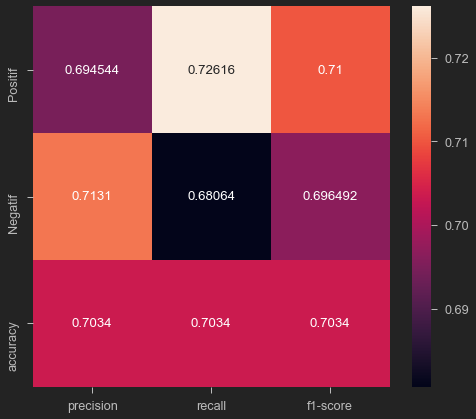

In [18]:
# So we can use an heatmap
clf_report : dict = classification_report(y_test,
                                   y_pred,
                                   target_names=["Positif", "Negatif"],
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-2].T, annot=True, fmt='g')

### Confusion matrix

<AxesSubplot:>

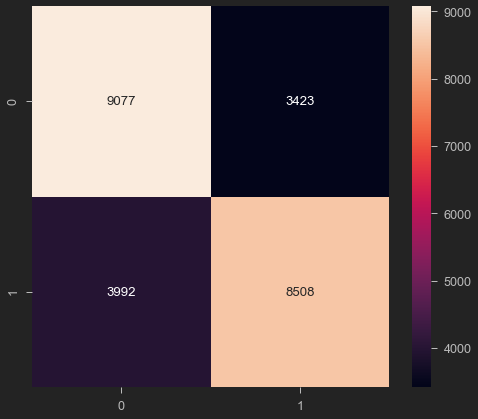

In [19]:
cm : numpy.ndarray = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

### Regularization 
We can do it directly in the logistic regression of sklearn as the parameter "penalty"

Regularization:

 / | None | l2 |
---------|-----|----|
Accuracy | 0.70244 | 0.70248 |


### Solver


Accuracy | None | l1 | l2 | Notes
---------|------|----|----|-----------
lbfgs | 0.70244 | / | 0.70248 | is the by-default solver
Saga | 0.70336 | 0.7034 | 0.70444 |  max_iter = 100000
newton-cg | 0.70244 | / | / | l2 couldn't converge
sag | 0.70296 | / | 0.70296 | 
liblinear | /  | 0.70276 | 0.70288 |